### Задача
Дано `rgb` изображение найти все прямогольники с градиентной заливкой с учетом пересечений, но без учета вложений (если `A` вложен в `B`, учитывается только `B`)

### Решение
Алгоритм будет состоять из двух частей:
1. Нахождение градиентных отрезков по горизонтали и вертикали
2. Объединение отрезков в прямоугольники

#### Часть 1
`Градиентной числовой последовательностью` назовем последовательность:
$$x_k = |a \cdot k + b|,$$
где `a` и `b` - произвольные действительные числа, а `||` - взятие по модулю

А чтобы понять, является ли заданная последовательность - градиентной, предлогается следующий алгорим
1. Находим mse аппроксимацию для точек `(k, a_k)`
2. Проверяем, что все значения восстанавливаются с некоторой погрешностью

Соответственно `градиентной линией` (вертикальной или горизонтальной) назовем отрезок из пикселей на изображении (длинны или ширины `1`), такой, что каждый из его каналов является `градиентной числовой последовательностью`.

Далее, введем некоторое ограничение, а именно, что две градиентных линии с разными параметрами нитенсивности могут пересекатья лишь в `1` пикселе (в действителности же это не совсем верно, благодаря округлению можно представить себе ситуацию, когда пересечение будет более чем в `1` пикселе, самый простой случай - длинное одноцветное пересечение)

Также заметим, что любой подотрезок градиентной линии, также является градиентной линией. Это обозначает, что мы сможем воспользоваться бинарным поиском при нахождении второго конца линии при заданной первой.

Соответственно сам алгортм таков: перебираем начало градиентной линии, бинпоиском находим конец, продолжаем с этого конца поиск дальше. Результат записываем в виде матрицы, где каждый элемент будет указывать на ближайший конец градиентной линии слева, справа, снизу или сверху.

#### Часть 2
Заметим, что для образования прямоугольника нам достаточно замостить его горизонтальными градиентными линиями и проверить, что на его границах справа и слева также градиентные линии.

Тогда сделаем это следующим образом: будем сохранять последний посещенный пиксель для каждой строчки. На кажом шаге будем выбирать строчку с минимальной `x` координатой из последних посещенных пикселей. Затем находить начало градиентной линии для этой точки. И формировать прямоугольники максимально возможной высоты, попутно проверяя необходимые условия на его формирование. 

Дополнительно отфильтруем маленькие прямоугольники и прямоугольники с небольшим количеством цветов.

In [1]:
from PIL import Image
import numpy as np

In [2]:
image = Image.open('test.png')
pixels = np.asarray(image, dtype='float')

In [3]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __str__(self):
        return '(' + str(self.x) + ', ' + str(self.y) + ')'

    def __repr__(self):
        return str(self)
        

class Region:
    def __init__(self, p_1, p_2):
        self.p_1 = p_1
        self.p_2 = p_2
        
    def height(self):
        return self.p_2.y - self.p_1.y
    
    def width(self):
        return self.p_2.x - self.p_1.x
    
    def size(self):
        return self.width() * self.height()
    
    def __str__(self):
        return '[' + str(self.p_1) + ', ' + str(self.p_2) + ']'

    def __repr__(self):
        return str(self)

In [4]:
class RegionsFinder:
    EPS = 1e-6
    
    def __init__(self, image, colors_limit=3, size_limit=100, length_limit=5, gradient_delta=0.6):
        self._image = image
        self._colors_limit = colors_limit
        self._size_limit = size_limit
        self._length_limit = length_limit
        self._gradient_delta = gradient_delta

        self._y_gradients, self._y_back_gradients = self._find_line_gradients(self._image)
        self._x_gradients, self._x_back_gradients = self._find_line_gradients(np.transpose(self._image, (1, 0, 2)))
        
        self._last_positions = np.full(self._image.shape[0], 0)
        
    def _is_gradient_numbers(self, numbers):
        n = len(numbers)
        x = np.arange(n)
        y = np.array(numbers)

        x_sum = x.sum()
        y_sum = y.sum()

        a = (n * (x * y).sum() - x_sum * y_sum) / (n * (x ** 2).sum() - x_sum ** 2)
        b = (y_sum - a * x_sum) / n

        for x_i, y_i in zip(x, y):
            y_pred = a * x_i + b
            if y_pred < y_i - self._gradient_delta - self.EPS or \
               y_pred > y_i + self._gradient_delta + self.EPS:
                return False

        return True

    def _is_gradient_pixels(self, line_pixels):
        for numbers in zip(*line_pixels):
            if not self._is_gradient_numbers(numbers):
                return False
        return True
    
    def _find_line_gradients(self, image_pixels):
        result = np.full(image_pixels.shape[:2], 0)
        result_back = np.full(image_pixels.shape[:2], 0)

        for i, line_pixels in enumerate(image_pixels):
            j = 0
            while j < len(line_pixels) - 1:
                lower = j + 2
                upper = len(line_pixels) + 1

                while upper - lower > 1:
                    middle = lower + int((upper - lower + 1) / 2)
                    if self._is_gradient_pixels(line_pixels[j:middle]):
                        lower = middle
                    else:
                        upper = middle

                for k in range(j, lower):
                    result[i][k] = lower
                    result_back[i][k] = j
                j = lower - 1

        return result, result_back
        
    def _check_region(self, region):
        if region.size() < self._size_limit:
            return False
        
        if region.height() < self._length_limit:
            return False
        if region.width() < self._length_limit:
            return False

        colors = set()
        for x in range(region.p_1.x, region.p_2.x):
            for y in range(region.p_1.y, region.p_2.y):
                colors.add(';'.join(map(str, self._image[y][x])))
                if len(colors) >= self._colors_limit:
                    return True
        return False
        
    def _extend_position(self, start, x_level, y_lower, y_upper):
        while y_lower >= 0 and \
              self._y_gradients[y_lower][start.x] >= x_level and \
              self._x_gradients[x_level][y_lower] == self._x_gradients[x_level][start.y]:
            self._last_positions[y_lower] = max(self._last_positions[y_lower], x_level)
            y_lower -= 1
        y_lower += 1

        while y_upper < self._image.shape[0] and \
              self._y_gradients[y_upper][start.x] >= x_level and \
              self._x_gradients[x_level][y_upper - 1] == self._x_gradients[x_level][start.y]:
            self._last_positions[y_upper] = max(self._last_positions[y_upper], x_level)
            y_upper += 1
        return y_lower, y_upper
        
    def _next_regions(self):
        y_start =  np.argmin(self._last_positions)
        x_start = self._y_back_gradients[y_start][self._last_positions[y_start]]
        start = Point(x_start, y_start)

        x_level = self._y_gradients[y_start][start.x] - 1   
        y_lower, y_upper = self._extend_position(start, x_level, y_start, y_start + 1)
        yield Region(Point(x_start, y_lower), Point(x_level + 1, y_upper))

        while True:
            x_level = start.x - 1

            if y_lower > 0:
                x_level_new = self._y_gradients[y_lower - 1][start.x] - 1
                if x_level_new < x_level and \
                   self._x_gradients[x_level_new][y_lower - 1] == self._x_gradients[x_level_new][start.y]:
                    x_level = max(x_level, x_level_new)
                    
            if y_upper < self._image.shape[0] - 1:
                x_level_new = self._y_gradients[y_upper][start.x] - 1
                if x_level_new < x_level and \
                   self._x_gradients[x_level_new][y_upper] == self._x_gradients[x_level_new][start.y]:
                    x_level = max(x_level, x_level_new)

            if x_level < start.x:
                break

            y_lower, y_upper = self._extend_position(start, x_level, y_lower, y_upper)
            yield Region(Point(x_start, y_lower), Point(x_level + 1, y_upper))
    
    def __iter__(self):
        while True:
            if np.min(self._last_positions) >= self._image.shape[1] - 1:
                break
                
            for region in self._next_regions():
                if self._check_region(region):
                    yield region

In [5]:
class GradientDetector:
    
    def __init__(self, image, colors_limit=3, size_limit=25, length_limit=5, gradient_delta=2.5):
        self._image = np.asarray(image, dtype='float')
        self._colors_limit = colors_limit
        self._size_limit = size_limit
        self._length_limit = length_limit
        self._gradient_delta = gradient_delta
    
    def find_regions(self):
        regions_finder = RegionsFinder(self._image,
                                       self._colors_limit,
                                       self._size_limit,
                                       self._length_limit,
                                       self._gradient_delta)
        return list(regions_finder)

    def make_region_mask(self):
        regions = self.find_regions()
        regions_mask = np.full(self._image.shape[:2], 1)
        
        for region in regions:
            for x in range(region.p_1.x, region.p_2.x):
                for y in range(region.p_1.y, region.p_2.y):
                    regions_mask[y][x] = 0
        
        return Image.fromarray(regions_mask.astype('uint8') * 255)

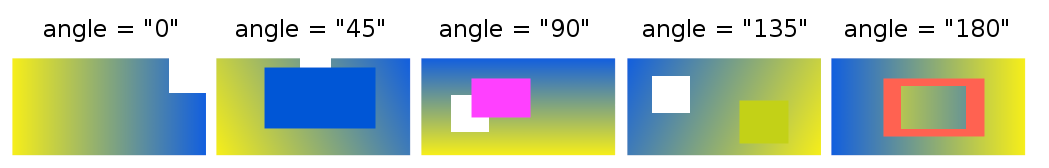

In [6]:
image

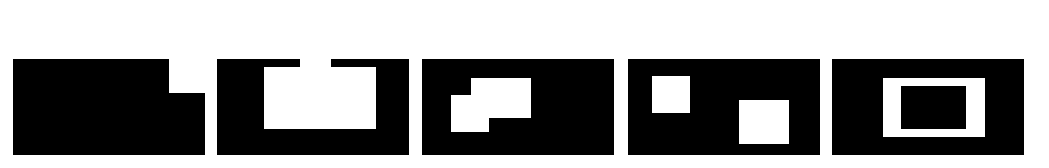

In [7]:
GradientDetector(image).make_region_mask()